# Предобработка и разметка данных: создание выборки под задачу детекции, инструменты разметки

**Типичный ("базовый") проект разработки в сфере компьютерного зрения:**
1. Постановка задачи
1. Сбор данных
1. Аудит данных
1. Отбор данных
1. Предобработка данных
1. Разметка данных
1. Создание обучающей и тестовой выборок
1. **Разработка модели компьютерного зрения:**

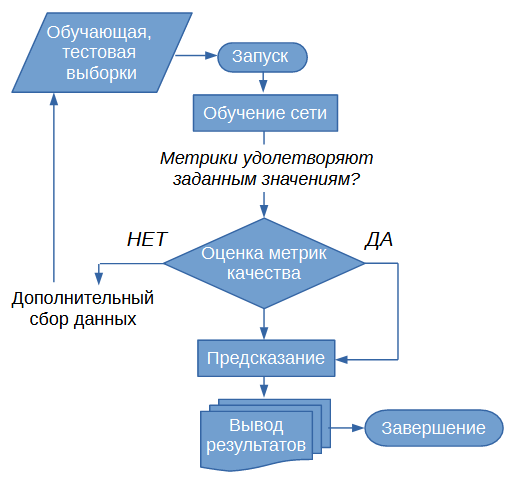

9. При необходимости - разработка аналитических модулей (фотометрии, статистики…)
10. Финальное тестирование (новые данные): баланс “специализации” и “генерализации” модели
11. "Упаковка" (развертывание): СLI-App, GUI-App, Cloud...

## Что учитывать при сборе данных для детекции (сегментации)?

1. Объект частично перекрыт другим объектом: берем?
    - целевым того же класса,
    - целевым того же класса,
    - нецелевым
    
*- Да. Вариативность относительных положений нескольких объектов - лучше обобщающие свойства обученной модели*
    
2. Объект на краю кадра, частично за кадром. Берем?

*- Зависит от задачи, но как правило, да (если большая часть объекта кадре)*

3. В кадре нет целевых объектов. Берем?

*- Да! особенно если нецелевой объект ПОХОЖ на целевой (размечаем ТОЛЬКО целевые объекты). От 5 до 40% - негативные примеры.* 

4. Важна консистентность (последовательность логики разметки - в контексте задачи): например, если контуры животных размечаются без передних ласт, то так должно быть везде. Если решено размечать объект на краю кадра (или перекрытый другим объектом) ТОЛЬКО если он виден больше чем на половину - так должно быть везде.

5. Выбросы. Иногда (очень редко) целевой объект встречается в крайне нетипичном виде или ракурсе. Решить - нудно ли вообще его размечать (пропуск менее 1% таких случаев может окупиться более точной признаковой моделью для остальных >99%, на которых модель покажет себя лучше).

6. Обязательна проверка собственной разметки: в проектах с несколькими сотнями изображений ошибки неизбежны (особенно если несколько классов). Проверять: точность контуров, верность меток классов, консистентность разметки.

## 1. Разбор видео на кадры

### Типичный кейс для БАС
- На входе - видеоданные (используем для обучения модели)
- Задача: детекция на видеоданных (обнаружение объектов одного идли нескольких классов на видео)

Функция читает видео по па адресу **src** по кадрам и сохраняет их как изображения в директорию **out**. Можно настроить выборку не всех, а каждого i-того кадра (параметр **sample**). **НЕ РЕКОМЕНДУЕТСЯ** сохранять все кадры (sample = 1) длинных видео: это долго и требует много места на диске! Кроме того, отличия между соседними кадрами очень малы - излишек почти одинаковых изображений.

In [12]:
import pandas as pd
import torch
import cv2
import os
import shutil
import natsort as ns
import json

In [ ]:
def video2frames(src, out, sample, xr, yr, x, y, w, h):
    
    if not os.path.exists(out):
        os.mkdir(out)
    
    cap = cv2.VideoCapture(src)
    
    if not cap.isOpened(): 
        print('Error opening video')
    
    i, s = 0, 0
    while cap.isOpened():
        ret, frame = cap.read()
        if ret == True:
            if i % sample == 0:
                frame = cv2.resize(frame, (xr, yr), cv2.INTER_NEAREST)
                
                '''
                Дополнительные шаги предобработки: ресайз,  вырезки, повороты...
                '''
                
#                 frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE) # cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180
#                 cv2.rectangle(frame , (y, x), (y+h, x+w), (255, 255, 255), thickness=2)
#                 frame = frame[x:w, y:h]
                cv2.imwrite(out + '/' + os.path.basename(src)[:-4] + '_' + str(i) + '.jpg', frame)

                s += 1
            i += 1
        else:
            break
    cap.release()
        
    return f'OK, {s} frames were saved'

In [ ]:
%%time
src = './1.mp4'
out = os.path.dirname(src) + '/frames'

cap = cv2.VideoCapture(src)
new_x, new_y = int(cap.get(3)), int(cap.get(4))

video2frames(src, out, 120, new_x, new_y, 0, 0, new_x, new_y) # sample = 120: берем только каждый 120-й кадр

## 2. Вырезки 640х640 из собранных кадров
Можно делать вырезки других размеров, но именно на 640х640 обучалась YOLO - открытая версия предобученной модели (что намного быстрее в отличие от обучения с нуля), то 640х640 - оптимальный размер изображений (или ближайший к нему со стороной, кратной 32). При этом размер тестовых изображений для предсказаний может отличаться (можно брать полные кадры видео).

**Как пользоваться функцией click_sampler:**
- Запуск: открытие стандратного окна OpenCV (иногда позади других окон - активировать его по клику на открывшейся иконке в панели задач Windows)
- ПКМ (правая кнопка мыши) на изображении: рисует границы вырезки и сохраняет данный фрагмент в указанную директорию (out). Н одном изображении можно набрать множество вырезок (страйтесь набирать полноразмерные - не близко к краям изображения)
- Любая кнопка на клавиатуре: вызывает следующее изображение. Не обязательно брать вырезки на каждом изображении, можно пролистывать кнопкой.
- Скрипт не завершится пока не пройдут все изображения! Если их много - это не быстрый процесс (лучше рзбивать на несколько партий и подавать для набора вырезок). Завершить выполнение в ноутбуке можно при помощи **restart kernel**.

In [ ]:
def click_sampler(name, size, out):
    
    if not os.path.exists(out):
        os.mkdir(out)
        
    if size[0] <= 0 or size[1] <= 0:
        raise ValueError ('tile size shuld be >= 0')
  
    img = cv2.imread(name)
    
    if size[0] > img.shape[0] or size[1] > img.shape[1]:
        print('Warnng: tile size > img size')
        pass
    
    img_c = img.copy()

    cv2.namedWindow(name, cv2.WINDOW_NORMAL)
    cv2.imshow(name, img)
    cv2.resizeWindow(name, img.shape[1], img.shape[0])

    coords = []

    def mouse_click(event, x, y, flags, param):
        
        if event == cv2.EVENT_RBUTTONDOWN:
            cv2.circle(img, (x, y), 10, (0, 0, 255), -1)
            x0, y0 = x - int(size[0]/2), y - int(size[1]/2)
            xw, yh = x + int(size[0]/2), y + int(size[1]/2)
            cv2.rectangle(img, (x0, y0), (xw, yh), (0, 0, 255), 3)
            cv2.imshow(name, img)
            coords.append((x, y))

        return coords

    cv2.setMouseCallback(name, mouse_click)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    t = 0
    nm, ext = os.path.basename(name)[:-4], os.path.basename(name)[-4:]
    
    for coord in coords:
        x, y = coord[0], coord[1]
        x0, y0 = x - int(size[0]/2), y - int(size[1]/2)
        xw, yh = x + int(size[0]/2), y + int(size[1]/2)
        
        if x0 < 0:
            x0 = 0 
        if y0 < 0:
            y0 = 0
            
        tile = img_c[y0:yh, x0:xw]
        print(out + '/' + os.path.basename(nm) + '_' + str(x)+ 'x' + str(y) + ext)
        cv2.imwrite(out + '/' + os.path.basename(nm)[:-1] + '_' + str(x)+ 'x' + str(y) + '.' + ext, tile)
                    
        t += 1
        
    return f'{t} tiles were generated'

In [ ]:
# for series of pic in the folder
pth = 'frames/'
out = '640x640'

if not os.path.exists(out):
    os.mkdir(out)

for file in ns.natsorted(os.listdir(pth)):
    print(pth + file)
    click_sampler(pth + file, (640,640), out)

## 3. Разметка данных в VIA
### (обзор других инструментов: LabelImage, Roboflow... на следующей Практике)
**[VGG Image Annotation (VIA)](https://www.robots.ox.ac.uk/~vgg/software/via/)** – браузерный инструмент разметки изображений для создания обучающих выборок с открытым исходным кодом, распространяемый по лицензии FreeBSD (свободное использование и производные работы, в т.ч. в проприетарном ПО). Основан на html, css и javascript, распространяется в виде самостоятельного html-файла - работа не зависит от доступа в сеть. Отличается  простотой графического интерфейса и наличием всех необходимых функций разметки для задач:
- обнаружения (локализация объекта, определение его класса и примерных размеров на изображении: разметка вида bounding boxes – ограничивающие прямоугольники или другие геометрические примитивы);
- сегментации (локализация объекта + определение класса + точные контуры объекта: разметка вида polygons – полигональные контуры) объектов;
- “секлетной разметки” (задачи обнаружения фигур и поз) задания ключевых точек (landmarks) и ломаных линий (polylines)

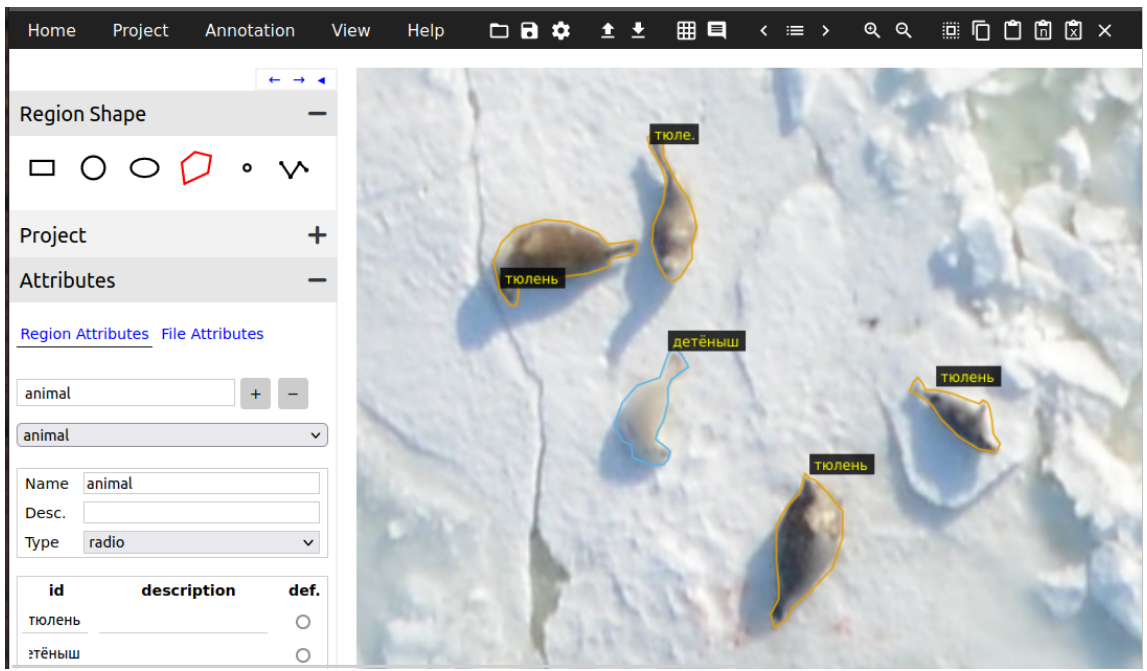

*Графический интерфейс VIA v 2.0.12, с увеличенным фрагментом оригинального изображения. Тюлени поделены на два класса: взрослые особи и детеныши и размечены контурами для задачи сегментации*

**Преимущества VIA:**
- Легкость и компактность. Объем файла VIA - около 400 Кб
- Кросс-платформенность за счет браузеного исполнения (это html-файл)
- Автономность: в отличие от продвинутых облачных решений работает везде
- Полностью свободное ПО: тип лицензии допускает любые варианты использования
- Необходимый минимум дял разметки изображений в простом и пронятном графичеком интерфейсе

Мы будем пользоваться версией **[VIA 2.0.12](https://www.robots.ox.ac.uk/~vgg/software/via/downloads/via-2.0.12.zip)**, более новые версии поддерживают разметку видео им аудиофайлов

## 4. VIA --> YOLO конвертер формата для разметки детекции

Почему YOLO? Исходно [YOLO - You Only Live Once](https://en.wikipedia.org/wiki/YOLO_(aphorism)) - поговорка, которую можно перевести примерно как "раз живём!", но разработчики новой сети-детектора (2015) ее немного изменили на "You Only Look Once", поскольку созданный детектор сравнительно быстро обучался. 
Сейчас YOLO не просто современная архитектура. В 2021 Ultralytics создали открытую и [мультизадачную платформу](https://docs.ultralytics.com/) на базе архитектур детектора YOLO разных версий и дополнили своими разработками. Сейчас YOLO может выполнять задачи:
- Классификации
- Детекции
- Сегментации
- Видео-трекинга
- Обнаружения поз тела (pose estimation)

Кроме универсальности по задачам [YOLO v8](https://docs.ultralytics.com/models/yolov8/) универсальна и по размерам модели **(соотношение "скорость-точность")**:
- YOLO-n nano
- YOLO-s small
- YOLO-m middle
- YOLO-l large
- YOLO-x x-large

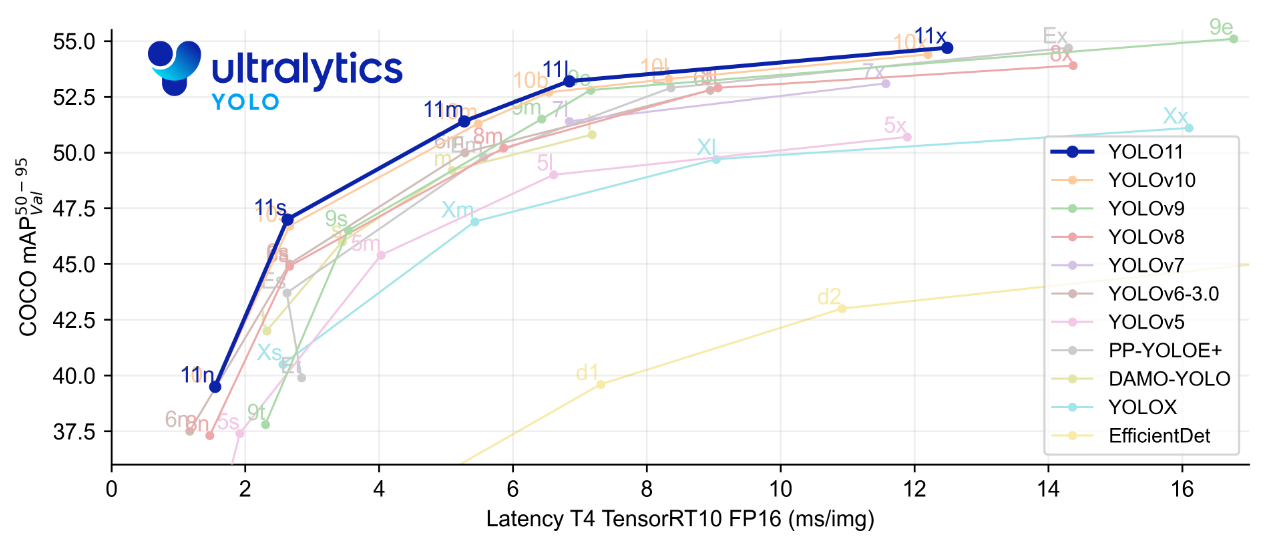

Это делает ее еще более универсальной. В отличие от VIA, YOLO предоставляется по лицензии GPLv3 (свободное использование только в некоммерческих проектах). Есть специальные версии YOLO: YOLO-World, YOLO-Drone и другие.

Генератор файлов разметок в формате YOLO по выборке по файлу .csv, сохраненному в VIA

### YOLO-формат разметки для детекции (пример для объектов одного класса):

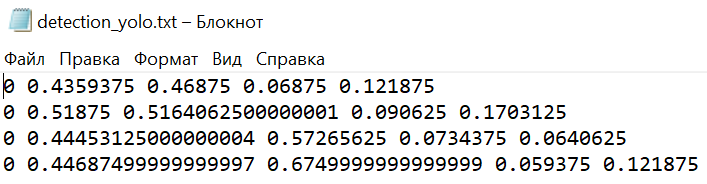

- Обычный текстовый файл (.txt, но с ТЕМ ЖЕ ИМЕНЕМ что изображение для которого он создан, можно сохранить и далее читать как .csv
- Каждая строка - разметка для отдельного объекта (первое значение == метка класса (0, 1, 2, 3 ... N), далее - координаты bbox в формате ```x, y, w, h```). Любой новый объект (этого же класса или других) - новая строка.
- Все координаты даны в ОТНОСИТЕЛЬНЫХ величинах (по отношению к W и H изображения), потому это float-значения. Для расчетов и преобразований нужно находить абсолютные значения и переводить в int() - округлять
- Разделитель значений - пробел
- Одно изображение - один текстовый файл разметки. Для изображений, которые не содержат целевых объектов рекомендуется в пару давать пустые текстовые файлы (тогда счимсло изоюражений соответсвует числ файлов разметки и это страхует от ошибок).

### Функция-генератор разметок в YOLO-формате по файлу разметок. сохраенному в .csv в VIA
ВНИМАНИЕ! Работоспособность функции подтверждена с версией **[VIA 2.0.12](https://www.robots.ox.ac.uk/~vgg/software/via/downloads/via-2.0.12.zip)**, с другими версиями работоспосбность может нарушаться.

In [ ]:
def VIA2YOLO_detect(data, cls_codes, out_dir, imgsize):
    
    '''
    Converts VIA detection (x,y,w,h-rects expected) annotations (one .csv file)
    to individual YOLO-formatted txt files for each img with objects.
    Empty imgs have no any files. Params:
    
    -data (path-like string) - source .csv  VIA annotation
    -clscodes (dict) - class name-to-index mapping: {'dog':0, 'cat':1 ...}
    -out - dir for generated .txt files (will be created if not exist)
    -imgsize (tuple of ints) - size (H,W) of annotated imgs (expected all the same)
    '''
    
    annot = pd.read_csv(data, index_col=0)
#     annot.drop(['file_size', 'file_attributes'], axis=1, inplace=True)
    
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
        
    for label, row in annot.iterrows():
        name, r_count, coords, cls = label, int(row[2]), json.loads(row[4]), json.loads(row[5])
        cls = str(cls)
        
#         # with empty files for empty pics 
        if r_count == 0:
            with open(out_dir + str(label[:-4]) + '.txt', 'w') as f:
                f.write('')
        
        if r_count == 1:
            if coords['name'] == 'rect':
                xywh = []
                xywh.append(coords['x']/imgsize[0] + (coords['width']/imgsize[0])/2)
                xywh.append(coords['y']/imgsize[1] + (coords['height']/imgsize[1])/2)
                xywh.append(coords['width']/imgsize[0])
                xywh.append(coords['height']/imgsize[1])

                for key in cls_codes.keys():
                    if key in cls:
                        cls_id = cls_codes[key]

                fin_str = str(cls_id) + ' ' + str(xywh)[1:-1].replace(',','')

                with open(out_dir + str(label[:-4]) + '.txt', 'w') as f:
                    f.write(fin_str + '\n')
            
        if r_count > 1:
            if coords['name'] == 'rect':
                xywh = []
                xywh.append(coords['x']/imgsize[0] + (coords['width']/imgsize[0])/2)
                xywh.append(coords['y']/imgsize[1] + (coords['height']/imgsize[1])/2)
                xywh.append(coords['width']/imgsize[0])
                xywh.append(coords['height']/imgsize[1])

                for key in cls_codes.keys():
                    if key in cls:
                        cls_id = cls_codes[key]

                fin_str = str(cls_id) + ' ' + str(xywh)[1:-1].replace(',','')

                with open(out_dir + str(label[:-4]) + '.txt', 'a') as f:
                    f.write(fin_str + '\n')
    
    return annot['region_attributes'].value_counts()

In [ ]:
data = 'from_VIA_detect.csv'
out_dir = './data_labels/'

# словарь имен классов - задает соответствие между текстовой разметкой из VIA и индексами для формата YOLO
mcodes = { 
    'object_A': 0,
    'object_B': 1,
    'object_C': 2,
}

mcodes = {'bear': 0} # единственный класс

VIA2YOLO_detect(data, mcodes, out_dir, (640, 640))

## Резюме:
1. Набираем кадры из видео, отбираем наиболее ценный обучающий материал
2. Делаем наиболее релевантные вырезки с учетом задачи
3. Размечаем вырезки в VIA или другом инструемнте (мы будем работать с VIA, можно с другим софтом, выдающим формат YOLO)
4. Переводим разметку в формат YOLO
5. Формируем обучающую и проверочную выборки

**3, 4, 5 - на следующей Практике**